In [1]:
import torch.nn as nn
import torch
import random
import os
import pandas as pd
from itertools import chain

<h6> In this notebook, we will try to unjumble a sentence using Encoder-Attention-Decoder Architecture built using <br><br>
 Recurrent Networks like GRU, LSTM and Bi-directional LSTMs.</h6>
<h6> The Data is located here: ../../Datasets/Jumble_Unjumble/ </h6>

#### Read Data

In [2]:
# train_df = pd.read_csv("../../Datasets/Jumble_Unjumble/Train_400.tsv",sep="\t")
# test_df = pd.read_csv("../../Datasets/Jumble_Unjumble/Test_100.tsv",sep="\t")
# print(train_df.shape, test_df.shape)
# train_df.head()

In [3]:
jumbled_df = pd.read_csv("../../Datasets/Jumble_Unjumble/processed_jumbled.txt",sep="\t",header=None)
unjumbled_df = pd.read_csv("../../Datasets/Jumble_Unjumble/processed_unjumbled.txt",sep="\t",header=None)
jumbled_df.columns = ["jumbled_sentences"]
unjumbled_df.columns = ["unjumbled_sentences"]
df = pd.concat([jumbled_df,unjumbled_df],axis=1)
train_df = df.sample(frac=0.8, random_state=42) 
test_df = df.drop(train_df.index)
print(train_df.shape, test_df.shape)
train_df.head()

(32368, 2) (8092, 2)


,jumbled_sentences,unjumbled_sentences
32760,tools and a man gardening inside two holding a...,a man and two women are inside a greenhouse ho...
31413,meandering at people of the walkway stand . up...,people stand at the bottom of a meandering wal...
4325,standing a rock . on man view the shorts a out...,a man in shorts is standing on a rock looking ...
28232,to a a in on shirt little red a holds pole nea...,a little girl in a red shirt holds on to a pol...
28438,children two in <unk> play the melting .,two children play in the melting <unk> .


#### Preprocess Train and Test Data
1. Lowercasing, removing stopwords. <br>
2. Stemming, Lemmetization. <br>
3. Tokenization. <br>
4. Here, we are just doing tokenization by splitting on space.

In [4]:
class Preprocessor:
    def __init__(self):
        self.tokenize_on = " "
    
    def tokenize(self,text_string):
        '''
        text_string = "This is one sentence."
        returns token_list = ["This","is","one","sentence."]
        '''
        token_list = text_string.split(self.tokenize_on)
        return token_list

In [5]:
preprocessor = Preprocessor()
train_df["jumbled_sentences"] = train_df["jumbled_sentences"].apply(lambda x: preprocessor.tokenize(x))
train_df["unjumbled_sentences"] = train_df["unjumbled_sentences"].apply(lambda x: preprocessor.tokenize(x))
test_df["jumbled_sentences"] = test_df["jumbled_sentences"].apply(lambda x: preprocessor.tokenize(x))
test_df["unjumbled_sentences"] = test_df["unjumbled_sentences"].apply(lambda x: preprocessor.tokenize(x))
print(train_df.shape, test_df.shape)
train_df.head()

(32368, 2) (8092, 2)


,jumbled_sentences,unjumbled_sentences
32760,"[tools, and, a, man, gardening, inside, two, h...","[a, man, and, two, women, are, inside, a, gree..."
31413,"[meandering, at, people, of, the, walkway, sta...","[people, stand, at, the, bottom, of, a, meande..."
4325,"[standing, a, rock, ., on, man, view, the, sho...","[a, man, in, shorts, is, standing, on, a, rock..."
28232,"[to, a, a, in, on, shirt, little, red, a, hold...","[a, little, girl, in, a, red, shirt, holds, on..."
28438,"[children, two, in, <unk>, play, the, melting,...","[two, children, play, in, the, melting, <unk>,..."


#### Create X_Encoder, X_Decoder and Y
1. X denotes Input, Y denotes Output. <br>
2. X_encoder is the matrix of tokens in jumbled_sentences, each sentence suffixed by "eos" token. <br>
3. X_decoder is the matrix of tokens in unjumbled_sentences, each sentence prefixed by "sos" token. X_decoder is required because we want to do <b>Teacher Forcing</b>, which means we want to provide the correct current token to decoder to predict next token, instead of relying only on its own prediction. <br>
4. Y is the matrix of unjumbled_sentences, each sentence suffixed by "eos" token. <br>

5. Do this for both train and test data.

In [6]:
def get_Xe_Xd_Y(dataframe, sos_token, eos_token):
    jumbled_sentences = dataframe["jumbled_sentences"].tolist()
    unjumbled_sentences = dataframe["unjumbled_sentences"].tolist()
    X_encoder_tokens = [el + [eos_token] for el in jumbled_sentences]
    X_decoder_tokens = [[sos_token] + el for el in unjumbled_sentences]
    Y_tokens = [el + [eos_token] for el in unjumbled_sentences]
    return X_encoder_tokens, X_decoder_tokens, Y_tokens

unknown_token = "<unk>"
pad_token = "<pad>"
sos_token = "<sos>"
eos_token = "<eos>"
X_encoder_tokens_tr, X_decoder_tokens_tr, Y_tokens_tr = get_Xe_Xd_Y(train_df, sos_token, eos_token)
X_encoder_tokens_test, X_decoder_tokens_test, Y_tokens_test = get_Xe_Xd_Y(test_df, sos_token, eos_token)
print("X Encoder train length:",len(X_encoder_tokens_tr))
print("X Encoder test length:",len(X_encoder_tokens_test))
print("Sample X_encoder_train:",X_encoder_tokens_tr[0])
print("Sample X_decoder_train:",X_decoder_tokens_tr[0])
print("Sample Y_train:",Y_tokens_tr[0])

X Encoder train length: 32368
X Encoder test length: 8092
Sample X_encoder_train: ['tools', 'and', 'a', 'man', 'gardening', 'inside', 'two', 'holding', 'are', '.', 'women', 'a', 'greenhouse', '', '<eos>']
Sample X_decoder_train: ['<sos>', 'a', 'man', 'and', 'two', 'women', 'are', 'inside', 'a', 'greenhouse', 'holding', 'gardening', 'tools', '.', '']
Sample Y_train: ['a', 'man', 'and', 'two', 'women', 'are', 'inside', 'a', 'greenhouse', 'holding', 'gardening', 'tools', '.', '', '<eos>']


#### Build Vocab
1. Generally, Vocab is created from both Encoder and Decoder Tokens, consider Senetence Translation for ex, where encoder and decoder tokens can be in different languages. <br>
2. We can create Vocab separately for Encder and Decoder tokens, or can create shared vocab. Shared Vocab is preferable though. <br>
3. Also, Vocab is generated from only Training Data. <br>
4. In this case, we are using only Encoder tokens to create Vocab because Decoder Tokens are the same. Also, we are using both Train and Test Dataset to create Vocab, as our datasize is small.

In [7]:
class VocabBuilder:
    def __init__(self,token_corpus,unknown_token=None,pad_token=None,sos_token=None,eos_token=None):
        '''
        token_corpus = ['tools', 'and', 'a', 'man', 'gardening', 'inside', 'two', 'holding', 'are', '.']
        '''
        self.token_corpus = token_corpus
        self.unknown_token = unknown_token or "<unk>"
        self.pad_token = pad_token or "<pad>"
        self.sos_token = sos_token or "<sos>"
        self.eos_token = eos_token or "<eos>"
        self.word_to_index, self.index_to_word = self.get_vocabs()
                        
    def get_vocabs(self):
        word_to_index = {}
        index_count = 0
        all_unique_words = set(self.token_corpus).difference(set(
            [self.unknown_token, self.pad_token, self.sos_token, self.eos_token]
        ))
        word_to_index[self.unknown_token] = 0
        word_to_index[self.pad_token] = 1
        word_to_index[self.sos_token] = 2
        word_to_index[self.eos_token] = 3
        
        for index, word in enumerate(all_unique_words):
            word_to_index[word] = index + 4
        if self.pad_token not in word_to_index: word_to_index[self.pad_token] = index + 1
        if self.sos_token not in word_to_index: word_to_index[self.sos_token] = index + 2
        if self.eos_token not in word_to_index: word_to_index[self.eos_token] = index + 3
        if self.unknown_token not in word_to_index: word_to_index[self.unknown_token] = index + 4
        index_to_word = {v:k for k,v in word_to_index.items()}
        return word_to_index, index_to_word

In [8]:
token_corpus_1 = list(chain.from_iterable(X_encoder_tokens_tr)) # flattens a 2D list ot 1D
token_corpus_2 = list(chain.from_iterable(X_encoder_tokens_test))  # flattens a 2D list ot 1D
token_corpus = token_corpus_1 + token_corpus_2
print(token_corpus[:20])

['tools', 'and', 'a', 'man', 'gardening', 'inside', 'two', 'holding', 'are', '.', 'women', 'a', 'greenhouse', '', '<eos>', 'meandering', 'at', 'people', 'of', 'the']


In [9]:
vocab_builder = VocabBuilder(token_corpus,unknown_token,pad_token,sos_token,eos_token)
print("WordToIndex Dict length:",len(vocab_builder.word_to_index))
print("IndexToWord Dict length:",len(vocab_builder.index_to_word))

WordToIndex Dict length: 5242
IndexToWord Dict length: 5242


#### Map X_encoder, X_decoder and Y using Vocab 

In [10]:
class Token_Index_Mapper:
    def __init__(self,token_to_index,index_to_token, unknown_token):
        self.token_to_index = token_to_index
        self.index_to_token = index_to_token
        self.unknown_token = unknown_token
    
    def get_encoding(self,sentence):
        '''
        sentence must be a list of tokens.
        Ex: ["Climate","change","is","a","pressing","global","issue"]
        '''
        encoded_sentence = []
        for token in sentence:
            if token in self.token_to_index: encoded_sentence.append(self.token_to_index[token])
            else: encoded_sentence.append(self.token_to_index[self.unknown_token])
        return encoded_sentence
    
    def get_decoding(self,encoded_sentence):
        '''
        encoded_sentence must be a list of vocab indices.
        Ex: encoded_sentence = [24,21,4,1,..] 
        '''
        sentence = [self.index_to_token[index] for index in encoded_sentence]
        return " ".join(sentence)

In [11]:
def map_tokens_to_indices(token_index_mapper, max_sequence_length, token_matrix):
    index_matrix = []
    for el in token_matrix:
        el = el[:max_sequence_length] # truncate sentence to max_seq_length
        if len(el) < max_sequence_length:
            pad_tokens_to_append = max_sequence_length - len(el)
            el = el + [pad_token]*pad_tokens_to_append
        index_matrix.append(token_index_mapper.get_encoding(el))
    return index_matrix

In [12]:
max_sequence_length = 25
token_index_mapper = Token_Index_Mapper(vocab_builder.word_to_index, vocab_builder.index_to_word, unknown_token)
X_encoder_indices_tr = map_tokens_to_indices(token_index_mapper, max_sequence_length, X_encoder_tokens_tr)
X_decoder_indices_tr = map_tokens_to_indices(token_index_mapper, max_sequence_length, X_decoder_tokens_tr)
Y_indices_tr = map_tokens_to_indices(token_index_mapper, max_sequence_length, Y_tokens_tr)

X_encoder_indices_test = map_tokens_to_indices(token_index_mapper, max_sequence_length, X_encoder_tokens_test)
X_decoder_indices_test = map_tokens_to_indices(token_index_mapper, max_sequence_length, X_decoder_tokens_test)
Y_indices_test = map_tokens_to_indices(token_index_mapper, max_sequence_length, Y_tokens_test)
print("X Encoder train length:",len(X_encoder_indices_tr))
print("X Encoder test length:",len(X_encoder_indices_test))
print("Sample X_encoder_train:",X_encoder_indices_tr[0])
print("Sample X_decoder_train:",X_decoder_indices_tr[0])
print("Sample Y_train:",Y_indices_tr[0])

X Encoder train length: 32368
X Encoder test length: 8092
Sample X_encoder_train: [324, 527, 3696, 1077, 891, 1744, 784, 15, 2841, 4202, 4549, 3696, 3904, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Sample X_decoder_train: [2, 3696, 1077, 527, 784, 4549, 2841, 1744, 3696, 3904, 15, 891, 324, 4202, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Sample Y_train: [3696, 1077, 527, 784, 4549, 2841, 1744, 3696, 3904, 15, 891, 324, 4202, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### Define Model 
1. Encoder: (Bi-Directional + BatchFirst + 2-Layer + StateLess)  GRU <br>
2. Attention: Bahadnau <br>
3. Decoder: Single Layer + TeacherForcing <br>

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super(Encoder, self).__init__()
        self.hid_dim = hid_dim
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.gru = nn.GRU(emb_dim, hid_dim, batch_first=True, bidirectional = True, num_layers = 2)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, debug=False):
        # X shape: (Batch_Size X Seq_Length)
        
        embedded = self.embedding(x)   
        # Embedded shape: (Batch_Size X Seq_Length X Embedding_Dim)
        
        dropped_out = self.dropout(embedded) 
        # DroppedOut shape: (Batch_Size X Seq_Length X Embedding_Dim)
        
        output, hidden = self.gru(dropped_out) 
        # Output shape: (Batch_Size X Seq_Length X D*Hidden_Dim), where D == 2 if Bi-directional, else 1. 
        # It contains h_t for all tokens, hence the Seq_Length in shape.
        # If more GRU layers are present, it contains h_t for all tokens but only from last layer.
        
        # Hidden shape: (D*NumLayers X Batch_Size X Hidden_Dim)
        # It contains the h_t for only last token of each sequence in the batch.
        # In case of multiple GRU layers:,
        # It can be thought of as a stack of (Batch_Size X Hidden_Dim) matrix, where each GRU Layer
        # is contributing 2 matrices (one for each direction in case of Bi-directional), 
        # such that the last layer's matrix is at the top of the stack and can be accessed using h_t[-1].
        
        hidden_concatenated = torch.cat((hidden[-1],hidden[-2]),axis=1)
        # hidden[-1] shape = Batch_Size X Hidden_Dim, we are only taking the last layer's matrix.
        # Since, the GRU is bi-directional we have 2 matrices of last layer, one for each direction (hidden[-1], hidden[-2]).
        # We need to concatenate them along Hidden_Dim.
        # So, hidden_concatenated shape = Batch_Size X 2*Hidden_Dim
        
        hidden_unsqueezed = hidden_concatenated.unsqueeze(0)
        # We are converting the 2-D matrix back to 3-D matrix,
        # with the first dimension (or the 0th dimension) == 1.
        
        if debug: 
            print("-----------Encoder----------:")
            print("Input Data shape:",x.shape)
            print("After Embedding Layer:",embedded.shape)
            print("After Dropout Layer:",dropped_out.shape)
            print("Outputs and hidden shape from GRU:",output.shape, hidden.shape)
            print("Unsqueezed hidden shape:", hidden_unsqueezed.shape)
            
        # Returning both the output and hidden state, output will be needed by Attention module, and 
        # unsqueezed hidden state will be needed by Decoder.    
        return output, hidden_unsqueezed

In [14]:
class Attention(nn.Module):
    # At any time step t of decoder, we need a weighted average of hidden state of all tokens of encoder.
    # The weights (with which we are multiplying) encoder hidden state must have following property:
    #   i. Their sum must be == 1.
    #   ii. Their values should also depend on which token we are going to predict in Decoder.
    # These weights are basically the attention weights and they are the output of the Attention module,
    # not the parameters.
    
    # Bahadnau's attention calculate the attention weights (alphas) like this:
    # alpha = softmax( V * tanh(U * decoder_prev_state + W * encoder_all_hidden_states))
    # For one sequence, alpha must be a vector of length (Seq_Length), 
    # for one batch, alpha = (Batch_Size X Seq_Length)
    # U, W and V are the parameters of Attention module.
    # At least, one dimension of W has to be of the dimension of encoder's hidden state for matmul compatibility
    # At least, one dimension of U has to of dimension of decoder's hidden state for matmul compatibility
    
    
    # encoder_all_hidden_states = (Batch_Size X Seq_Length X 2*Hidden_Dim), since Encoder is Bi-Directional.
    # We reshape it to (Batch_Size X 2*Hidden_Dim X Seq_Length) for allowing matrix multiplication with W.
    # We chose W = (2*Hidden_Dim X 2*Hidden_Dim), 
    # W has to be repeated Batch_Size times to multiply with encoder_all_hidden_states.
    # torch.matmul() takes care of it by broadcasting W in Batch_Size dimension.
    # W * encoder_all_hidden_states  = (Batch_Size X 2*Hidden_Dim X Seq_Length)
    
    # decoder_prev_state = (1 X Batch_Size X 2*Hidden_Dim) (since, Encoder is Bi-directional)
    # We squeeze it to (Batch_Size X 2*Hidden_Dim) and then repeat it Seq_Length times.
    # So that, decoder_prev_state = (Batch_Size X 2*Hidden_Dim X Seq_Length)
    # We chose U = (2*Hidden_Dim X 2*Hidden_Dim), it will also be broadcasted like W.
    # U * decoder_prev_state = (Batch_Size X 2*Hidden_Dim X Seq_Length)
    
    # V is [1 X 2*Hidden_Dim] vector
    # V * tanh(U * decoder_prev_state + W * encoder_all_hidden_states) = (Batch_Size X 1 X Seq_Length)
    # We squeeze it to get (Batch_Size X Seq_Length), and apply softmax to get alpha.
    
    
    
    def __init__(self, decoder_hidden_dim, encoder_hidden_dim):
        super(Attention, self).__init__()
        self.U = torch.randn(encoder_hidden_dim, decoder_hidden_dim, requires_grad=True)
        self.W = torch.randn(encoder_hidden_dim, encoder_hidden_dim, requires_grad=True)
        self.tanh = nn.Tanh()
        # Implements: tanh(U * decoder_prev_state + W * encoder_all_hidden_states)
        # U = 2*Hidden_Dim X 2*Hidden_Dim
        # W = 2*Hidden_Dim X 2*Hidden_Dim
         
        self.V = torch.randn(1, encoder_hidden_dim, requires_grad=True)
        # Implements: V * tanh(U * decoder_prev_state + W * encoder_all_hidden_states)
        # V = 1 X 2*Hidden_Dim
        
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, op_from_encoder, st_minus_one_from_decoder, debug=False):
        # op_from_enoder shape = (Batch_Size X Seq_Length X 2*Hidden_Dim)
        # It has to be reshaped to (Batch_Size X 2*Hidden_Dim X Seq_Length)
        reshaped_op_from_encoder = op_from_encoder.reshape(
            op_from_encoder.shape[0],op_from_encoder.shape[2],op_from_encoder.shape[1]
        )
        
        # st_minus_one_from_decoder shape = (1 X Batch_Size X 2*Hidden_Dim)
        # Squeeze it to make (Batch_Size X 2*Hidden_Dim)
        # UnSqueeze it to make (Batch_Size X 2*Hidden_Dim X 1)
        # And repeat it to Seq_Length times to get (Batch_Size X 2*Hidden_Dim X Seq_Length)
        seq_length = reshaped_op_from_encoder.shape[2]
        squeezed_st_minus_1 = st_minus_one_from_decoder.squeeze(dim=0)
        unsqueezed_st_minus_1 = squeezed_st_minus_1.unsqueeze(dim=2)
        reshaped_st_minus_one_from_decoder = unsqueezed_st_minus_1.repeat(1,1,seq_length)
        
        rnn_op = self.tanh(
            torch.matmul(self.U,reshaped_st_minus_one_from_decoder) + torch.matmul(self.W, reshaped_op_from_encoder)
        )
        # rnn_op = (Batch_Size X Hidden_Dim X Seq_Length)
        batch_size = op_from_encoder.shape[0]
        linear_op = torch.matmul(self.V, rnn_op) # (Batch_Size X 1 X Seq_Length)
        squeezed_linear_op = linear_op.squeeze(dim=1) # squeezing along dim = 1 will give (Batch_Size X Seq_Length)
        softmax_op = self.softmax(squeezed_linear_op) # Applies softmax along dim = 1, which means along Seq_Length
        
        if debug: 
            print("-----------Attention----------:")
            print("Encoder All Hidden State Shape:",op_from_encoder.shape)
            print("Reshaped Encoder All Hidden State Shape:",reshaped_op_from_encoder.shape)
            print("Decoder Previous Hidden State Shape:",st_minus_one_from_decoder.shape)
            print("Decoder Previous Hidden State Squeezed Shape:",squeezed_st_minus_1.shape)
            print("Decoder Previous Hidden State UnSqueezed Shape:",unsqueezed_st_minus_1.shape)
            print("Decoder Reshaped Previous Hidden State Shape:",reshaped_st_minus_one_from_decoder.shape)
            print("After RNNCell:",rnn_op.shape)
            print("After Linear Layer:",linear_op.shape)
            print("After Squeezing Linear Layer:",squeezed_linear_op.shape)
            print("Final alphas shape, after softmax:", softmax_op.shape)
        
        return softmax_op

In [15]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim):
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.gru = nn.GRU(emb_dim, hid_dim,  batch_first=True) # Decoders are almost always unidirectional.
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
    def forward(self, x, attn_weighted_encoder_input, prev_hidden_state, debug=False):
        # In Decoder, we concat the attn_weighted_encoder_input to x (after embedding).
        
        # X shape: (Batch_Size X Seq_Length)
        # X (decoder) is only required when we do Teacher Forcing.
        
        seq_length = x.shape[1]
        
        embedded = self.embedding(x)
        # Embedded shape: (Batch_Size X Seq_Length X Embedding_Dim)
        
        attn_weighted_encoder_input_unsq = attn_weighted_encoder_input.unsqueeze(dim=1)
        attn_weighted_encoder_input_rep = attn_weighted_encoder_input_unsq.repeat(1,seq_length,1)
        # attn_weighted_encoder_input = (Batch_Size X 2* Hidden_Dim)
        # We need to make it of size (Batch_Size X Seq_Length X 2* Hidden_Dim) to append to embedded.
        # So we first unsqueeze it to make (Batch_Size X 1 X 2* Hidden_Dim), and then repeat Seq_length times
        # to make (Batch_Size X Seq_Length X 2* Hidden_Dim)
        
        concatenated_input = torch.cat((embedded, attn_weighted_encoder_input_rep), axis=2)
        # concatenated_input = (Batch_Size X Seq_Length X (Embedding_Dim + 2* Hidden_Dim))
        
        output, hidden = self.gru(embedded, prev_hidden_state)
        # Output shape: (Batch_Size X Seq_Length X D*Hidden_Dim), where D == 2 if Bi-directional, else 1.
        # Bi-directional Decoder does not make sense, except for very rare cases.
        # Hidden shape: (D*NumLayers X Batch_Size X Hidden_Dim)
        # It contains the h_t for only last token of each sequence in the batch.
        
        reshaped_output = output.reshape(-1,output.shape[2])
        # Reshaped_Output shape = (Batch_Size*Seq_Length X Hidden_Dim) [Basically a 2-D Matrix]
        # Since we need to calculate loss on each token of the batch, the output has to be 
        # reshaped into Batch_Size*Seq_Length X Hidden_Dim.
        # -1 in the reshape function tells Pytorch to figure out the size of Tensor by itself.
        # output.shape[2] is the Hidden_Dim (obvious from Output Shape: Batch_Size X Seq_Length X D*Hidden_Dim)
        # So, the reshape operation figures out the size of 0th dimension, 
        # given that size of 1st dimension ==  Hidden_Dim. 
        
        prediction = self.fc_out(reshaped_output)
        # prediction shape: (Batch_Size*Seq_Length X Vocab_Size)
        # For each input token, we get the vector of vocab size consisting of logits.
        # We take the softmax of each vector to convert vector of logits to vector of probabilities.
        # Then we take argmax of each vector to get the predicted token.
        
        if debug: 
            print("-----------Decoder----------:")
            print("Input Data shape, X:",x.shape, ", Previous step hidden state:", prev_hidden_state.shape)
            print("Attention Weighted Enocder Hidden State:",attn_weighted_encoder_input.shape)
            print("After Embedding Layer:",embedded.shape)
            print("After Concatenating with AttentionWeightedEnocderHidden:",concatenated_input.shape)
            print("Outputs and hidden shape from GRU:",output.shape, hidden.shape)
            print("Reshaped Output:", reshaped_output.shape)
            print("After FC layer:", prediction.shape)
        return prediction, hidden

In [16]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, attention, decoder, device, teacher_forcing_ratio, max_seq_len, token_index_mapper):
        super(Seq2Seq, self).__init__() 
        self.encoder = encoder
        self.attention = attention
        self.decoder = decoder
        self.device = device
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.max_seq_len = max_seq_len
        self.token_index_mapper = token_index_mapper
    
    def forward(self, encoder_input, decoder_input, debug=False): 
        # Encoder Input: (Batch_Size X Seq_Length)
        # Decoder Input: (Batch_Size X Seq_Length), but we have to send input to decoder one token at a time, 
        # so at each time step, Decoder Input shape is (Batch_Size X 1)
        # At first time step, decoder_input is <sos>. So sos_tokens shape = (Batch_Size X 1)
        # At later time steps: decoder_input will either be the predicted_token from previous time step or the teacher token.
        
        batch_size = encoder_input.shape[0]
        sos_tokens = [[token_index_mapper.token_to_index["<sos>"]]*batch_size]
        sos_tokens = torch.tensor(sos_tokens).reshape(-1,1).to(self.device) # 1st token to decoder is <sos>.
        
        # the output matrix will have shape (Batch_Size, Seq_Length, Vocab_Size)
        outputs = torch.zeros(batch_size,self.max_seq_len,len(token_index_mapper.token_to_index)).to(self.device)
        
        encoder_outputs, encoder_hidden = self.encoder(encoder_input, debug)
        # encoder_outputs: (Batch_Size X Seq_length X 2*Hidden_Dim), since the Encoder is BiDirectional
        for i in range(self.max_seq_len):
            if i == 0: 
                attention_weights = self.attention(encoder_outputs, encoder_hidden, debug)
                # attention_weights = (Batch_Size X Seq_Length)
                unsqueezed_attention_weights = attention_weights.unsqueeze(dim=2) # for torch.mul
                # unsqueezed_attention_weights = (Batch_Size X Seq_Length X 1)
                weighted_avg = torch.sum(torch.mul(encoder_outputs, unsqueezed_attention_weights),dim=1)
                # torch.mul() for 1 sequence of the batch, will multiply each attn_weight to 
                # its repective encoder hidden state, giving out Seq_Length X 2*Hidden_Dim
                # When done across batch, torch.mul() gives (Batch_Size X Seq_Length X 2*Hidden_Dim)
                # Now, we have to do sum across Seq_Length (for doing weighted avg)
                # So, torch.sum(dim = 1)
                # weighted_avg = (Batch_Size X 2*Hidden_Dim)
                decoder_op, decoder_hidden = self.decoder(sos_tokens,weighted_avg, encoder_hidden, debug)
            else:
                teacher_force = torch.rand(1).item() < self.teacher_forcing_ratio
                attention_weights = self.attention(encoder_outputs, decoder_hidden, debug)
                unsqueezed_attention_weights = attention_weights.unsqueeze(dim=2) # for torch.mul
                weighted_avg = torch.sum(torch.mul(encoder_outputs, unsqueezed_attention_weights),dim=1)
                if teacher_force:
                    # we need the ith token of all sequences in the batch
                    # decoder_input[:,i] will be of len (BatchSize)
                    # reshape(-1,1), means calculate the 0th dimension given that 1st dimension == 1
                    # So, decoder_input[:,i].reshape(-1,1) will be (Batch_Size X 1)
                    decoder_op, decoder_hidden = self.decoder(
                        decoder_input[:,i].reshape(-1,1),weighted_avg, decoder_hidden, debug
                    )
                else:
                    # decoder_op is (Batch_Size X Vocab_Size)
                    # decoder_hidden like encoder_hidden is (1 X Batch_Size X Hidden_Dim)
                    softmax_op = torch.softmax(decoder_op,axis=1) # softmax_op is (Batch_Size X Vocab_Size)
                    pred_tokens = torch.argmax(softmax_op,axis=1) # pred_tokens is torch.tensor([]) of len (Batch_Size)
                    reshaped_pred_tokens = pred_tokens.reshape(-1,1) # reshape to (Batch_Size X 1)
                    decoder_op, decoder_hidden = self.decoder(
                        reshaped_pred_tokens.to(self.device),weighted_avg, decoder_hidden, debug
                    )
                    if debug:
                        print("Seq2Seq softmax_op",softmax_op.shape)
                        print("Seq2Seq pred_tokens",pred_tokens.shape)
                        print("Seq2Seq reshaped_pred_tokens",reshaped_pred_tokens.shape)
            # We need to put the decoder_op for each token into output matrix.
            outputs[:,i,:] = decoder_op
        
        # Finally we have to return the output in the shape (Batch_Size*Seq_Length, Vocab_Size)
        # So, we are again using the same concept of reshape() to return final_matrix.
        return outputs.reshape(-1,len(token_index_mapper.token_to_index))

In [17]:
def predict_on_1_input(model, Xe_b, token_index_mapper, device, max_sequence_length):
    model.eval()
    sos_token = torch.tensor([[token_index_mapper.token_to_index["<sos>"]]]).to(device) # 1st token as decoder input is <sos>.
    unjumbled_sentence = []
    with torch.no_grad():
        attention_matrix = []
        encoder_outputs, encoder_hidden = model.encoder(Xe_b)
        for i in range(max_sequence_length):
            if i == 0: 
                # At 1st time step, input to decoder is the index of <sos> token.
                # And the hidden state input to decoder is Encoder's hidden state.
                attention_weights = model.attention(encoder_outputs, encoder_hidden)
                attention_matrix.append(attention_weights.tolist()[0])
                unsqueezed_attention_weights = attention_weights.unsqueeze(dim=2) # for torch.mul
                weighted_avg = torch.sum(torch.mul(encoder_outputs, unsqueezed_attention_weights),dim=1)
                decoder_op, decoder_hidden = model.decoder(sos_token, weighted_avg,encoder_hidden)
            else: 
                # After 1st time step, input to decoder is the predicted token of previous time step.
                # and hidden state input to decoder is the hidden state output of decoder of previous time step.
                
                # To get the predicted token of previous time step:
                # first, do the softmax on decoder_op of previous time step
                softmax_op = torch.softmax(decoder_op,axis=1) # decoder_op is (1 X Vocab_Size),

                # next, take the token with max probability
                # (softmax_op is also [1 X Vocab_Size], as we have taken softmax along axis=1, which
                # has simply converted the logits to probabilities.)
                # torch.argmax() returns a tensor([]). The list will contain as many elements as 0th dimension of softmax_op.
                # because we are taking argamx along axis = 1.
                # In this case, softmax_op has only 1 token in 0th dimension, so the list has only 1 element.
                # torch.tensor([]).tolist() gives out the []
                predicted_token = torch.argmax(softmax_op,axis=1).tolist()
                attention_weights = model.attention(encoder_outputs, decoder_hidden)
                attention_matrix.append(attention_weights.tolist()[0])
                unsqueezed_attention_weights = attention_weights.unsqueeze(dim=2) # for torch.mul
                weighted_avg = torch.sum(torch.mul(encoder_outputs, unsqueezed_attention_weights),dim=1)
                decoder_op, decoder_hidden = model.decoder(
                    torch.tensor([predicted_token]).to(device), weighted_avg, decoder_hidden
                )
                
                unjumbled_sentence.append(token_index_mapper.index_to_token[predicted_token[0]])
                if predicted_token[0] == token_index_mapper.token_to_index["<eos>"]: break
        print("_______________________________________")
        print(unjumbled_sentence)
        return attention_matrix, unjumbled_sentence

### Sample Training And Prediction

In [18]:
INPUT_DIM = len(token_index_mapper.token_to_index) # Size of source vocabulary 
OUTPUT_DIM = len(token_index_mapper.token_to_index) # Size of target vocabulary 
ENC_EMB_DIM = 256 
DEC_EMB_DIM = 256 
HID_DIM = 512 
ENC_DROPOUT = 0.5 
device = "cpu"
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT) 
attn = Attention(2*HID_DIM, 2*HID_DIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, 2*HID_DIM) 
model = Seq2Seq(enc, attn, dec, device, 0.7, max_sequence_length, token_index_mapper).to(device)
optimizer = torch.optim.Adam(model.parameters()) 
criterion = nn.CrossEntropyLoss(ignore_index=token_index_mapper.token_to_index["<pad>"])

In [19]:
data_index = 6
batch_size = 5

model.train()
optimizer.zero_grad()
Xe_b = torch.tensor(X_encoder_indices_tr[data_index:data_index+batch_size]).to(device)
Xd_b = torch.tensor(X_decoder_indices_tr[data_index:data_index+batch_size]).to(device)
Y_b = torch.tensor(Y_indices_tr[data_index:data_index+batch_size]).to(device)
print(Xe_b.shape,Xd_b.shape,Y_b.shape)
output = model(Xe_b, Xd_b, debug=True)
loss = criterion(output, Y_b.view(-1))
loss.backward()
optimizer.step()

torch.Size([5, 25]) torch.Size([5, 25]) torch.Size([5, 25])
-----------Encoder----------:
Input Data shape: torch.Size([5, 25])
After Embedding Layer: torch.Size([5, 25, 256])
After Dropout Layer: torch.Size([5, 25, 256])
Outputs and hidden shape from GRU: torch.Size([5, 25, 1024]) torch.Size([4, 5, 512])
Unsqueezed hidden shape: torch.Size([1, 5, 1024])
-----------Attention----------:
Encoder All Hidden State Shape: torch.Size([5, 25, 1024])
Reshaped Encoder All Hidden State Shape: torch.Size([5, 1024, 25])
Decoder Previous Hidden State Shape: torch.Size([1, 5, 1024])
Decoder Previous Hidden State Squeezed Shape: torch.Size([5, 1024])
Decoder Previous Hidden State UnSqueezed Shape: torch.Size([5, 1024, 1])
Decoder Reshaped Previous Hidden State Shape: torch.Size([5, 1024, 25])
After RNNCell: torch.Size([5, 1024, 25])
After Linear Layer: torch.Size([5, 1, 25])
After Squeezing Linear Layer: torch.Size([5, 25])
Final alphas shape, after softmax: torch.Size([5, 25])
-----------Decoder----

In [20]:
# Randomly select one sentence from Test Data to Predict.
data_index = random.randint(0,100)
# Since its only 1 sentence, we need to convert into a 2-D list before sending it to torch.tensor()
Xe_b = torch.tensor([X_encoder_indices_test[data_index]]).to(device)
print("Test Jumbled sentence:",X_encoder_tokens_test[data_index])
print("Test Unjumbled sentence:", Y_tokens_test[data_index]) 
attention_matrix, _ = predict_on_1_input(model, Xe_b, token_index_mapper, device, max_sequence_length)

Test Jumbled sentence: ['and', 'catch', 'in', 'for', '.', 'a', 'waiting', 'come', 'him', 'throwing', 'air', 'up', 'the', 'water', 'so', 'him', 'man', 'can', 'in', 'a', 'down', 'boy', 'he', 'little', 'to', '', '<eos>']
Test Unjumbled sentence: ['a', 'man', 'in', 'water', 'throwing', 'a', 'little', 'boy', 'up', 'in', 'the', 'air', 'and', 'waiting', 'for', 'him', 'to', 'come', 'down', 'so', 'he', 'can', 'catch', 'him', '.', '', '<eos>']
_______________________________________
['a', 'a', 'in', 'in', 'a', 'in', 'in', 'sox', 'range', 'paddles', 'scottish', 'remote', 'dew', 'fences', 'streaks', 'kisses', 'top', 'containing', 'violin', 'motorcycles', 'punches', 'punches', 'easel', 'coverings']


## For Actual Training

In [25]:
device = "cpu" #torch.device("cuda:0")
batch_size = 100
INPUT_DIM = len(token_index_mapper.token_to_index) # Size of source vocabulary 
OUTPUT_DIM = len(token_index_mapper.token_to_index) # Size of target vocabulary 
ENC_EMB_DIM = 128 
DEC_EMB_DIM = 128 
HID_DIM = 400 
ENC_DROPOUT = 0.5 
DEC_DROPOUT = 0.5
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, ENC_DROPOUT) 
attn = Attention(2*HID_DIM, 2*HID_DIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, 2*HID_DIM) 
model = Seq2Seq(enc, attn, dec, device, 0.9, max_sequence_length, token_index_mapper).to(device)
optimizer = torch.optim.Adam(model.parameters()) 
criterion = nn.CrossEntropyLoss(ignore_index=token_index_mapper.token_to_index["<pad>"])
epochs = 10

In [26]:
for i in range(epochs):
    model.train()
    epoch_loss = 0
    for j in range(0,len(X_encoder_indices_tr),batch_size):
        optimizer.zero_grad()
        Xe_b = torch.tensor(X_encoder_indices_tr[j:j+batch_size]).to(device)
        Xd_b = torch.tensor(X_decoder_indices_tr[j:j+batch_size]).to(device)
        Y_b = torch.tensor(Y_indices_tr[j:j+batch_size]).to(device)
        op = model(Xe_b,Xd_b)
        loss = criterion(op,Y_b.reshape(-1))
        loss.backward()
        optimizer.step()
        batch_loss = loss.item()
        epoch_loss += batch_loss
        if j%3000 == 0: print("Epoch:",i,"Batch:",j,"Loss:",batch_loss)
    print("______________________________________")
    print("Epoch Loss:",epoch_loss)
    
    # Randomly select one sentence from Test Data to Predict.
    data_index = random.randint(0,100)
    # Since its only 1 sentence, we need to convert into a 2-D list before sending it to torch.tensor()
    Xe_b = torch.tensor([X_encoder_indices_test[data_index]]).to(device)
    print("Test Jumbled sentence:",X_encoder_tokens_test[data_index])
    print("Test Unjumbled sentence:", Y_tokens_test[data_index]) 
    attention_matrix, _ = predict_on_1_input(model, Xe_b, token_index_mapper, device, max_sequence_length)
    print("_______________________________________")

Epoch: 0 Batch: 0 Loss: 8.57169246673584
Epoch: 0 Batch: 3000 Loss: 4.3253960609436035
Epoch: 0 Batch: 6000 Loss: 3.867767333984375
Epoch: 0 Batch: 9000 Loss: 3.3064990043640137
Epoch: 0 Batch: 12000 Loss: 3.38032865524292
Epoch: 0 Batch: 15000 Loss: 3.3024888038635254
Epoch: 0 Batch: 18000 Loss: 2.9526124000549316
Epoch: 0 Batch: 21000 Loss: 3.2422266006469727
Epoch: 0 Batch: 24000 Loss: 2.8822708129882812
Epoch: 0 Batch: 27000 Loss: 2.7922346591949463
Epoch: 0 Batch: 30000 Loss: 2.482647657394409
______________________________________
Epoch Loss: 1056.891522884369
Test Jumbled sentence: ['running', 'a', 'beach', 'white', 'rocky', 'is', 'down', 'a', '.', 'dog', '', '<eos>']
Test Unjumbled sentence: ['a', 'white', 'dog', 'is', 'running', 'down', 'a', 'rocky', 'beach', '.', '', '<eos>']
_______________________________________
['a', 'white', 'dog', 'is', 'running', 'a', 'white', 'dog', '.', '', '<eos>']
_______________________________________
Epoch: 1 Batch: 0 Loss: 2.4957590103149414
Ep

______________________________________
Epoch Loss: 167.81465411186218
Test Jumbled sentence: ['the', 'black', 'runs', 'dog', 'the', '.', 'through', 'water', '', '<eos>']
Test Unjumbled sentence: ['the', 'black', 'dog', 'runs', 'through', 'the', 'water', '.', '', '<eos>']
_______________________________________
['the', 'black', 'dog', 'runs', 'through', 'the', 'water', '.', '', '<eos>']
_______________________________________
Epoch: 9 Batch: 0 Loss: 0.402446985244751
Epoch: 9 Batch: 3000 Loss: 0.5237300395965576
Epoch: 9 Batch: 6000 Loss: 0.3517068326473236
Epoch: 9 Batch: 9000 Loss: 0.42072418332099915
Epoch: 9 Batch: 12000 Loss: 0.43324390053749084
Epoch: 9 Batch: 15000 Loss: 0.35038942098617554
Epoch: 9 Batch: 18000 Loss: 0.40581122040748596
Epoch: 9 Batch: 21000 Loss: 0.395102322101593
Epoch: 9 Batch: 24000 Loss: 0.45425039529800415
Epoch: 9 Batch: 27000 Loss: 0.5414351224899292
Epoch: 9 Batch: 30000 Loss: 0.496710866689682
______________________________________
Epoch Loss: 143.4975

#### Visualizing the Attention Weights

In [27]:
import matplotlib.pyplot as plt

In [28]:
data_index = random.randint(0,100)
# Since its only 1 sentence, we need to convert into a 2-D list before sending it to torch.tensor()
Xe_b = torch.tensor([X_encoder_indices_test[data_index]]).to(device)
print("Test Jumbled sentence:",X_encoder_tokens_test[data_index])
print("Test Unjumbled sentence:", Y_tokens_test[data_index]) 
attention_matrix, predicted_sentence = predict_on_1_input(model, Xe_b, token_index_mapper, device, max_sequence_length)

Test Jumbled sentence: ['people', 'of', '.', 'beach', 'crowd', 'the', 'at', '', '<eos>']
Test Unjumbled sentence: ['crowd', 'of', 'people', 'at', 'the', 'beach', '.', '', '<eos>']
_______________________________________
['crowd', 'of', 'people', 'at', 'the', 'beach', '.', '', '<eos>']


C:\Users\niprakash\AppData\Local\Temp\ipykernel_45820\3811298408.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + X_encoder_tokens_test[data_index], rotation=90)
C:\Users\niprakash\AppData\Local\Temp\ipykernel_45820\3811298408.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + Y_tokens_test[data_index])


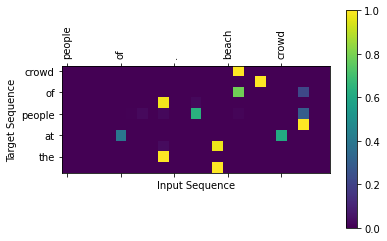

In [30]:
fig, ax = plt.subplots() 
cax = ax.matshow(attention_matrix, cmap='viridis') 
# Set axis labels 
ax.set_xticklabels([''] + X_encoder_tokens_test[data_index], rotation=90) 
ax.set_yticklabels([''] + Y_tokens_test[data_index]) 
# Add colorbar 
plt.colorbar(cax) 
plt.xlabel('Input Sequence') 
plt.ylabel('Target Sequence')
plt.show()

In [ ]:
len(attention_matrix), len(attention_matrix[0])